
# Heart Attack Prediction

### Objective:
Given the dataset of 303 patients and 13 variables, build an ML solution to predict whether a person is to have a heart attack or not. 

The entire solution is divided into following components:<br><br>
**1. Data Loading and Understanding**

**2. Exploratory Data Analysis**<br>
    2.1 Sanity checks<br>
    2.2 Missing values<br>
    2.3 Correlation<br>
    2.4 Visualizations<br>
    2.5 Outliers <br>

**3. Data Preparation**<br>
    3.1 New Features<br>
    3.2 Data Preparation for Modeling<br>
    3.3 Feature Selection/Dimension Reductionality<br>

**4. Models Application and Evaluation**<br>
    4.1 Applying Models<br>
    4.2 Model Evaluation<br>

**5. Conclusion**<br>
**6. Recommendation**<br>
**7. Appendix:**<br>
A. Profiling using pandas_profiling<br>
B. Dimension Reduction using PCA<br>
C. RFECV method<br>
D. Hyperparameter Tuning for all the models



In [111]:
# Importing Pandas and NumPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# importing required models
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
!pip install xgboost==1.3.3
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import RFE

# pandas profiling
!pip install pandas-profiling
import pandas_profiling


## 1. Data Loading and Understanding

In [112]:
# Reading dataset
heart_data = pd.read_csv("take_home_assign_set.csv")
heart_data.head(5)

,age,gender,chest_pain_type,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_heart_rate,ex_ind_ang,prev_peak,slope,vessels_num,thal_result,output
0,63,1,Non-anginal pain,145,233,Yes,Normal,150,No,2.3,0,0,1,1
1,37,1,Atypical angina,130,250,No,ST-T wave normality,187,No,3.5,0,0,2,1
2,41,0,Typical angina,130,204,No,Normal,172,No,1.4,2,0,2,1
3,56,1,Typical angina,120,236,No,ST-T wave normality,178,No,0.8,2,0,2,1
4,57,0,NaN,120,354,No,ST-T wave normality,163,Yes,0.6,2,0,2,1


### Column Definitions:

- **age**: Patient age.
- **gender**: Patient gender (Unspecified).
- **chest_pain_type**: Chest Pain type.
        Typical angina
        Atypical angina
        Non-anginal pain
        Asymptomatic
- **rest_blood_pressure**: Resting blood pressure (in mm Hg).
- **cholesterol**: Cholesterol in mg/dl fetched via BMI sensor.
- **fast_blood_sugar**: Fasting blood sugar > 120 mg/dl.
- **rest_ecg**: Resting electrocardiographic results.
        Normal.
        Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV).
        Showing probable or definite left ventricular hypertrophy by Estes' criteria.
- **max_heart_rate**: Maximum heart rate achieved.
- **ex_ind_ang**: Exercise induced angina (Yes, No).
- **prev_peak**: Old peak.
- **slope**: Slope.
- **vessels_num**: Number of major vessels (0-3).
- **thal_result**: Thalium Stress Test result.
- **output**: 0 = less chance of heart attack, 1 = more chance of heart attack.


## 2. Exploratory Data Analysis

Although an integral part of any Data Science project and crucial to the full success of the analysis, Exploratory Data Analysis (EDA) can be an incredibly labour intensive and time consuming process. Recent years have seen modern approaches and libraries aimed at speeding up the process and in this project first I will quicly demonstrate via traditional approach and then I would apply "pandas_profiling", an open-source library meant for profiling the data to gain some insights.

We will perform below tasks in this section:

2.1 Sanity checks<br>
    2.2 Missing values<br>
    2.3 Correlation<br>
    2.4 Visualizations<br>
    2.5 Outliers <br>
    
### 2.1 Sanity checks

In [113]:
print(heart_data.shape)
heart_data.info()
# 9240 rows

(303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  303 non-null    int64  
 1   gender               303 non-null    int64  
 2   chest_pain_type      160 non-null    object 
 3   rest_blood_pressure  303 non-null    int64  
 4   cholesterol          303 non-null    int64  
 5   fast_blood_sugar     303 non-null    object 
 6   rest_ecg             303 non-null    object 
 7   max_heart_rate       303 non-null    int64  
 8   ex_ind_ang           303 non-null    object 
 9   prev_peak            303 non-null    float64
 10  slope                303 non-null    int64  
 11  vessels_num          303 non-null    int64  
 12  thal_result          303 non-null    int64  
 13  output               303 non-null    int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 33.3+ KB


There are 303 records with 13 independent variables and one dependent variable("output")

### 2.2 Missing values

In [114]:
# Number of missing value rows in each column
heart_data.isnull().sum(axis=0)

age                      0
gender                   0
chest_pain_type        143
rest_blood_pressure      0
cholesterol              0
fast_blood_sugar         0
rest_ecg                 0
max_heart_rate           0
ex_ind_ang               0
prev_peak                0
slope                    0
vessels_num              0
thal_result              0
output                   0
dtype: int64

Only **chest_pain_type** column has missing values and it constitute **~47%** of the total records. Let's look at the number of observations by each value of chest type

In [115]:
heart_data.chest_pain_type.value_counts()

Atypical angina     87
Typical angina      50
Non-anginal pain    23
Name: chest_pain_type, dtype: int64

So, only 3 out of the 4 distinct values are present. We cannot simply impute the mode value i.e. "Typical angina" to the missing data because 
1. the % of missing records is very high and imputing any value will have an adverse effect on the output model
2. chest_type is a significant feature in deciding the outcome i.e. output field

Upon further analysis, we see that the "Asymptomatic" value which is a valid option is **completly** missing from this. **Asymtomatic** are the chest pain not showing signs of disease. My assumption is the records are missing for the patients who do not show any signs of diseases. Before imputing the null values with "asymptomatic" value, let's verify if the data is true with respect to the output. The output should not depend on the asymptomatic value if our assumption is correct. 

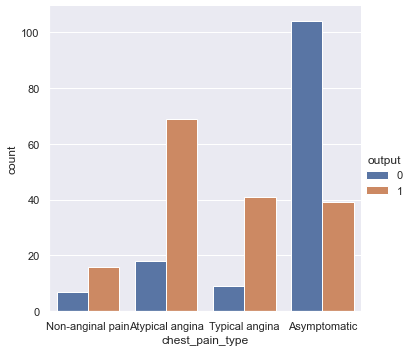

In [116]:
df_test = heart_data
df_test.loc[df_test['chest_pain_type'].isnull(),'chest_pain_type'] = 'Asymptomatic'
sns.catplot(x = "chest_pain_type", hue = "output", data = df_test, kind = "count")

#### Missing value treatment

Clearly, the above chart shows that our assumption is correct as the probability of a person prone to heart disease is significantly less for missing records. So, this confirms that we can confidently impute missing values with "Asymptomatic" value. 

Let's now impute these values in the main data set.

In [117]:
# imputing missing records of chest pain with "Aymptomatic"
df_imputed=heart_data
df_imputed.loc[df_imputed['chest_pain_type'].isnull(),'chest_pain_type'] = 'Asymptomatic'
# check null values
df_imputed.isnull().sum(axis=0)


age                    0
gender                 0
chest_pain_type        0
rest_blood_pressure    0
cholesterol            0
fast_blood_sugar       0
rest_ecg               0
max_heart_rate         0
ex_ind_ang             0
prev_peak              0
slope                  0
vessels_num            0
thal_result            0
output                 0
dtype: int64

### 2.3 Correlation among features

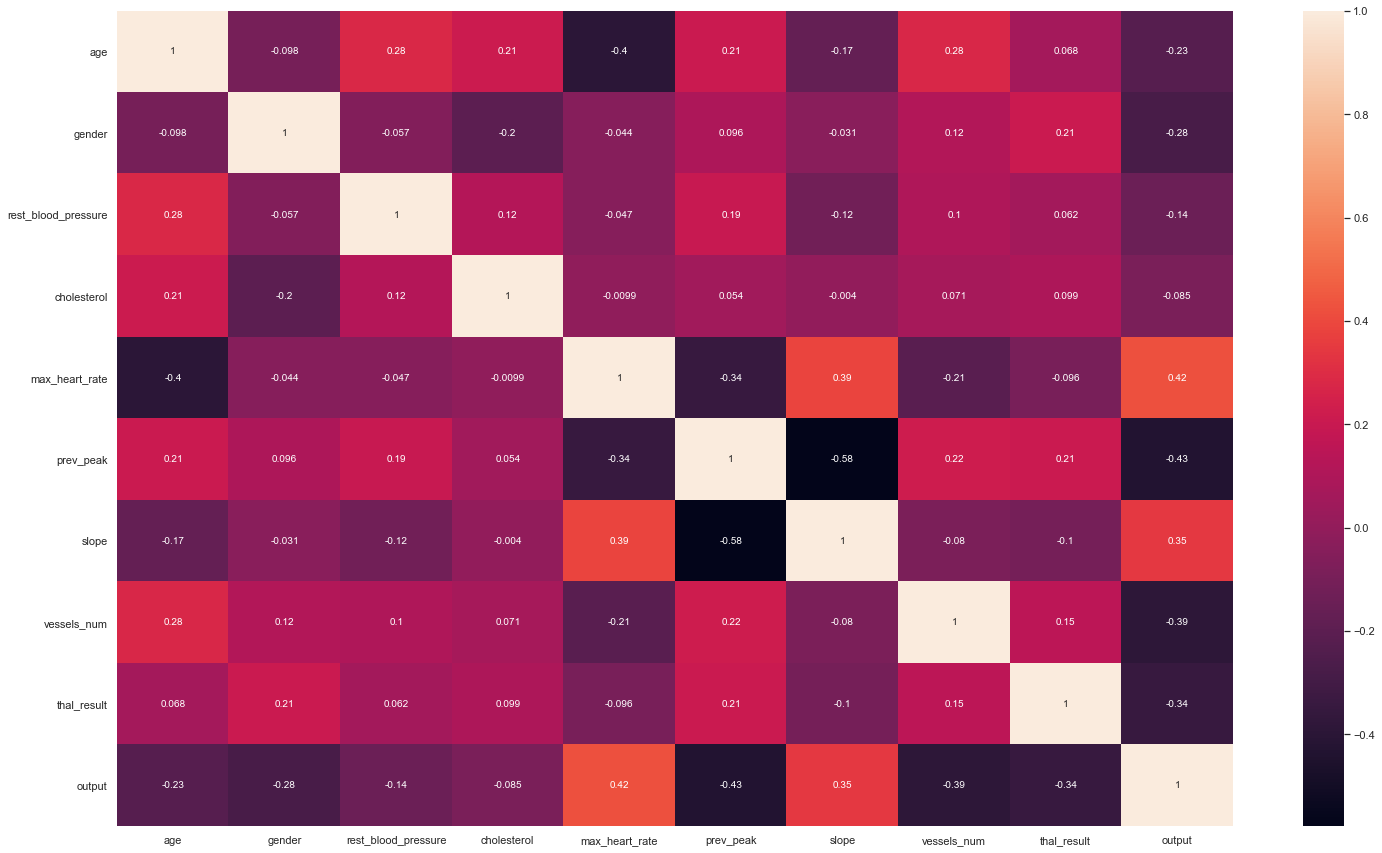

In [118]:
# Let's see the correlation matrix 
plt.figure(figsize = (25,15))        # Size of the figure
sns.heatmap(df_imputed.corr(),annot = True)
plt.show()

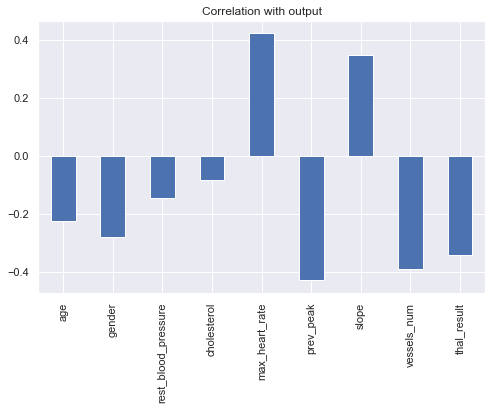

In [119]:
df_imputed.drop('output', axis=1).corrwith(heart_data.output).plot(kind='bar', grid=True, figsize=(8, 5), 
                                                   title="Correlation with output")

There seems to be some level of correlation between following fields:
slope and prev_peak
age and max_heart_rate

And by looking at the correlation between output (dependent variable) and all independent variables, the most important features seems to be:
1. max_heart_rate
2. prev_peak
3. vessels_num
4. thai_result
5. slope

Cholesterol and rest_blood_pressure don't show much impact on the output.

We have also used **pandas_profiling** to quickly see more insights for all the columns and the same is included in the $Appendix$

Below fields are correlated with one another after looking results from above correlation chart and pandas profiling chart:
- age and max_hear_rate
- slope and prev_peak
- rest_ecg and prev_peak
- max_heart_rate and ex_ind_ang
- gender and thal_result 




#### Handling duplicate record ####

There is one duplicate record and it is highly possible that it is from another person with the same vitals. If a persons identification was also availabe and if that is duplicate, then we would have removed the duplicate record. For now, we will not remove this one duplicate record.

In [120]:
df_imputed[df_imputed.duplicated()]

,age,gender,chest_pain_type,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_heart_rate,ex_ind_ang,prev_peak,slope,vessels_num,thal_result,output
164,38,1,Atypical angina,138,175,No,ST-T wave normality,173,No,0.0,2,4,2,1



### 2.4 Visualiazations
Now, let's plot some charts to visualize distribution and relation of different fields

#### Class Ouput Distribution


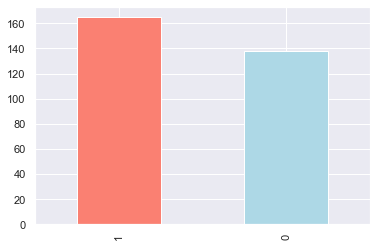

In [121]:
df_imputed.output.value_counts().plot(kind="bar", color=["salmon", "lightblue"])


$Conclusion:$ Both the output classes have enough number of cases. So there is no issue of class imbalance
 

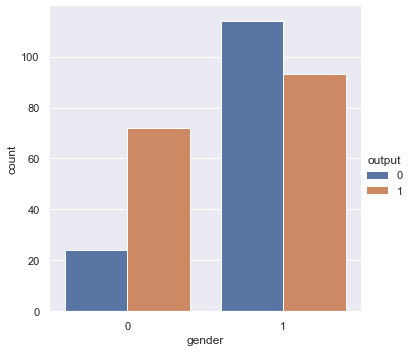

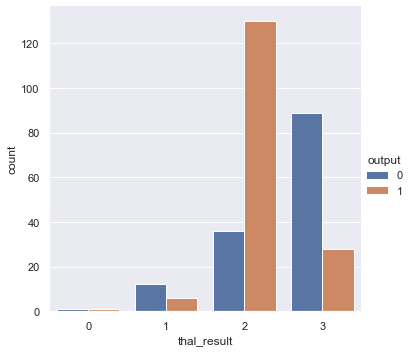

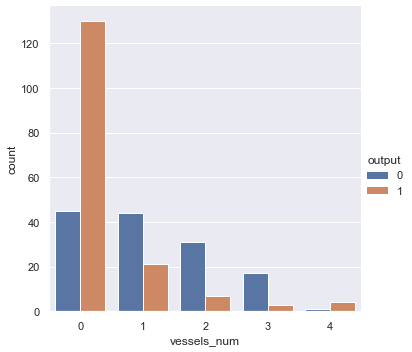

In [122]:
sns.catplot(x = "gender", hue = "output", data = heart_data, kind = "count")
sns.catplot(x = "thal_result", hue = "output", data = heart_data, kind = "count")
sns.catplot(x = "vessels_num", hue = "output", data = heart_data, kind = "count")

$Comments:$
- There is a high proportion of heart attacks for gender 0 than that for gender 1
- Thal_result =2 has a high proportion of heart attacks than that with thal_result 0, 1 and 3
- Vessel_nums 0 shows more prone to heart attacks

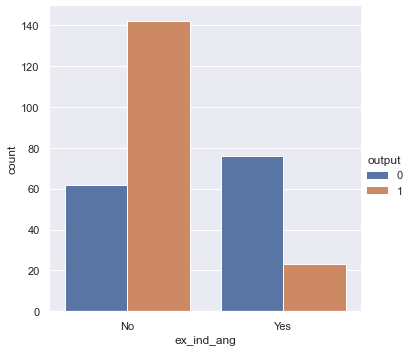

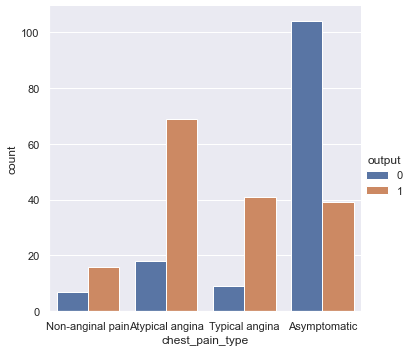

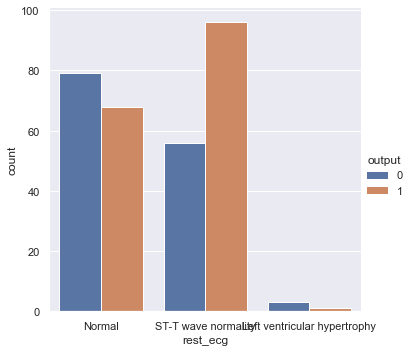

In [123]:
#fig, (ax0,ax1) = plt.subplots (1, 2, figsize=(15, 5))
sns.catplot(x = "ex_ind_ang", hue = "output", data = heart_data, kind = "count")
sns.catplot(x = "chest_pain_type", hue = "output", data = heart_data, kind = "count")
sns.catplot(x = "rest_ecg", hue = "output", data = heart_data, kind = "count")



$Comments:$
- Data shows proportion of herat attacks in non-exercise induced angina
- Normally, majority of the chest pains are associated with heart attacks. However, "typical" and "atypical" angina chest pains are more prone to heart attacks
- Resting electrocardiographic results with abnormal ST-T wave are at mroe risk at heart disease

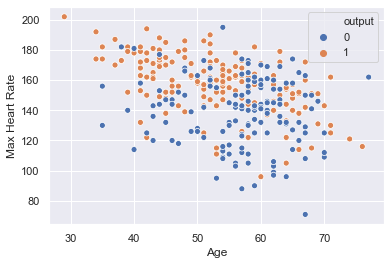

In [124]:
sns.scatterplot(data=heart_data, x="age", y="max_heart_rate", hue="output")
plt.xlabel('Age')
plt.ylabel('Max Heart Rate')
plt.show()


$Comments:$
With increase in the age, the max heart rate seems to be decreasing. The chances of having an heart attack seems to be more concentrated at the top-left region indicating people with higher max heart rate, which is generally found in the lower age group, are more prone to heart attacks.

Text(0.5, 1.0, 'Proness to heart attach with respect to Slope')

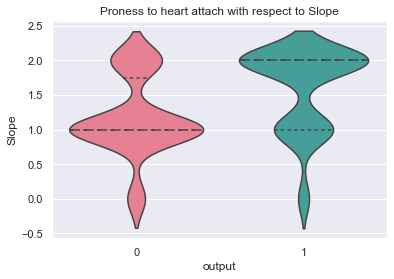

In [125]:
sns.violinplot(y = 'slope', x='output', inner='quartile',data = heart_data, palette="husl")
plt.ylabel("Slope")
plt.xlabel('output')
plt.title("Proness to heart attach with respect to Slope")

$Comments:$
Slope value of 2 shows a high degree of association with heart attach. Although, there are some exceptions for slope 1 with heart attacks cases, but majority of them do not show proness to heart disease.

### 2.5 Outliers

**Why it is needed?**<br>
Because in data science, we often want to make assumptions about a specific population. Extreme values, however, can have a significant impact on conclusions drawn from data or machine learning models. 

Below are the two reasons why outliers might be present in the dataset:
1. Variability in the data
2. An Experimental measurement error

Let's check if there are any outliers present in the continuous fields.

In [126]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
df_imputed.describe(percentiles=[.01,.25,.5,.75,.90,.95,.99])

,age,gender,rest_blood_pressure,cholesterol,max_heart_rate,prev_peak,slope,vessels_num,thal_result,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,131.623762,246.264026,149.646865,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,17.538143,51.830751,22.905161,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,35.000000,0.000000,100.000000,149.000000,95.020000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,47.500000,0.000000,120.000000,211.000000,133.500000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,130.000000,240.000000,153.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,140.000000,274.500000,166.000000,1.600000,2.000000,1.000000,3.000000,1.000000
90%,66.000000,1.000000,152.000000,308.800000,176.600000,2.800000,2.000000,2.000000,3.000000,1.000000
95%,68.000000,1.000000,160.000000,326.900000,181.900000,3.400000,2.000000,3.000000,3.000000,1.000000


Upon primary observation, we see there might be outliers in rest_blood_pressure, cholesterol, and max_heart_rate fields. Let's plot the box plot to see if how many and how extreme are they.

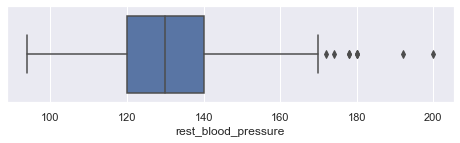

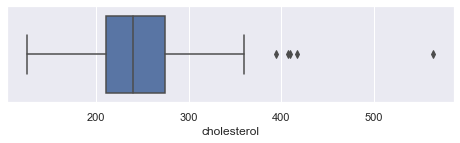

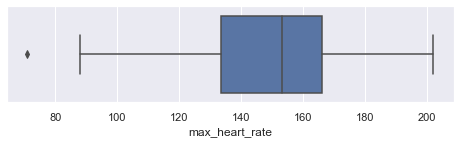

In [127]:
#Let's visualize outliers in these columns

sns.set(style="darkgrid")

fig = plt.figure(figsize = (8,6))
plt.subplot(3, 1, 1)
sns.boxplot(x = df_imputed["rest_blood_pressure"])
plt.show()

fig = plt.figure(figsize = (8,6))
plt.subplot(3, 1, 2)
sns.boxplot(x = df_imputed["cholesterol"])
plt.show()

fig = plt.figure(figsize = (8,6))
plt.subplot(3, 1, 3)
sns.boxplot(x = df_imputed["max_heart_rate"])
plt.show()

As there are hardly any outliers and also the values for each of them seems to be correct for that particular feature, we skip treating them. 

In case of a huge number of outliers, we would have treated them using Inter-Quartile-Range method to cap the min and max value to (Q1 - 1.5xIQR) and (Q3 + 1.5xIQR)

## 3. Data Preparation for the Models

In this section, we will see if a new feature can be created or an existing feature should be grouped to form a new feature. Later, we will prepare the data needed for modeling purposes, this includes - scaling, creating dummy variables, splitting data into train-test and so on.

3.1 New Features<br>
3.2 Data Preparation for Modeling<br>
3.3 Feature Selection/Dimension Reductionality

### 3.1 New Features

Create a categorical field for age. For this, we will see how the distribution of age, the number of patients prone and not prone to heart disease.

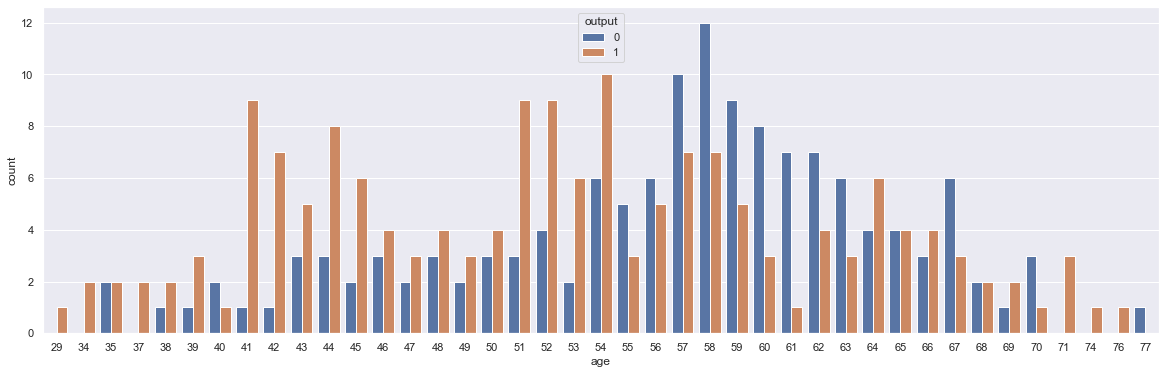

In [128]:
fig = plt.figure(figsize = (20,6))
sns.countplot(heart_data['age'],hue=heart_data['output'])

From the above distribution, we can see people age less than 41 falls under one category where the number of samples are less also the number of people prone to heart disease. Age 41-45 are at high risk of heart attacks, whereas age 46-50 seems to have patients with prone to heart disease just slightly higher than the one not prone. However, age 51-55 again shows high risk patients, whereas, we can group patients age more than 55 into one category.


In [129]:
conditions = [
    (df_imputed['age'] <= 40),
    (df_imputed['age'] > 40) & (df_imputed['age'] <= 45),
    (df_imputed['age'] > 45) & (df_imputed['age'] <= 50),
    (df_imputed['age'] > 50) & (df_imputed['age'] <= 55),
    (df_imputed['age'] > 55)]
choices = ['<=40', '41-45', '45-50','51-55','>55']
df_imputed['age_grp'] = np.select(conditions, choices)
df2 = df_imputed.drop(['age'],axis=1)

In [130]:
df2.head()

,gender,chest_pain_type,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_heart_rate,ex_ind_ang,prev_peak,slope,vessels_num,thal_result,output,age_grp
0,1,Non-anginal pain,145,233,Yes,Normal,150,No,2.3,0,0,1,1,>55
1,1,Atypical angina,130,250,No,ST-T wave normality,187,No,3.5,0,0,2,1,<=40
2,0,Typical angina,130,204,No,Normal,172,No,1.4,2,0,2,1,41-45
3,1,Typical angina,120,236,No,ST-T wave normality,178,No,0.8,2,0,2,1,>55
4,0,Asymptomatic,120,354,No,ST-T wave normality,163,Yes,0.6,2,0,2,1,>55


### 3.2 Data Preparation for Modeling
#### a. Dummy variables for categorical variables
Most of the algorithms (or ML libraries) require data to be present in numerical values or produce better result with numerical variable. In python, library “sklearn” requires features in numerical arrays. Therefore, we will create dummy variables for all the categorical fields. We will just change the values to 0 and 1 for boolean variables.


In [131]:
# Changing the slope, vessels_num and thal_result variables from int into str as they are categorical variable and 
# we will create dummy variables for them
df2['slope'] = df2['slope'].astype(str)
df2['vessels_num'] = df2['vessels_num'].astype(str)
df2['thal_result'] = df2['thal_result'].astype(str)

# use dummy variable to encode below categorical values
var_cat = ['chest_pain_type','rest_ecg','age_grp','slope','vessels_num','thal_result']
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy = pd.get_dummies(df2[var_cat], drop_first=True)


# Adding the results to the master dataframe
df2 = pd.concat([df2, dummy], axis=1)

# Dropping the original variable
df2.drop(var_cat, axis=1, inplace = True)


In [132]:
# Converting Yes to 1 and No to 0 for boolean variables
df2['ex_ind_ang'] = df2['ex_ind_ang'].map({'Yes': 1, 'No': 0})
df2['fast_blood_sugar'] = df2['fast_blood_sugar'].map({'Yes': 1, 'No': 0})


In [133]:
df2.info()
# there are 25 features and one output variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gender                            303 non-null    int64  
 1   rest_blood_pressure               303 non-null    int64  
 2   cholesterol                       303 non-null    int64  
 3   fast_blood_sugar                  303 non-null    int64  
 4   max_heart_rate                    303 non-null    int64  
 5   ex_ind_ang                        303 non-null    int64  
 6   prev_peak                         303 non-null    float64
 7   output                            303 non-null    int64  
 8   chest_pain_type_Atypical angina   303 non-null    uint8  
 9   chest_pain_type_Non-anginal pain  303 non-null    uint8  
 10  chest_pain_type_Typical angina    303 non-null    uint8  
 11  rest_ecg_Normal                   303 non-null    uint8  
 12  rest_ecg

#### b. Scaling and Test-Train split

Machine learning algorithm just sees number — if there is a vast difference in the range say few ranging in thousands and few ranging in the tens, and it makes the underlying assumption that higher ranging numbers have superiority of some sort. So these more significant number starts playing a more decisive role while training the model.

The machine learning algorithm works on numbers and does not know what that number represents. A weight of 10 grams and a price of 10 dollars represents completely two different things — which is a no brainer for humans, but for a model as a feature, it treats both as same.

Therefore, it is important for to bring all the features into one scale before feeding into the model. Below, we will use StandardScaler(). It scales each field such that the distribution centered around 0, with a standard deviation of 1.

https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

In [143]:
# Get the design matrix X and the respone variable y.
y = df2['output'].astype(int)
X = df2.drop('output', axis = 1)

# scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Cols_to_Scale = X.columns
X[Cols_to_Scale] = scaler.fit_transform(X[Cols_to_Scale])

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)


In [144]:
print("Train X shape: ", X_train.shape)
print("Test X shape: ", X_test.shape)

Train X shape:  (242, 25)
Test X shape:  (61, 25)


In [145]:
y_train.value_counts()
# we have enough number of records in both the classes

1    135
0    107
Name: output, dtype: int64

### 3.3 Feature Selection and  Dimension Reductionality

As we have seen in the EDA, there are some columns which are collinear among one another. It is worth exploring which features we can drop without effecting the model performance. There are many ways to check the collinearity (and subsequently dropping these fields) or reducing the dimensions (eg. PCA/tSNE)

Before removing features or performing dimension reductionality, we will check the performance with all the features using Logistic Regression. We treat this as a base model and compare the performance of the models after feature selection process. 


In [147]:
# Base model
#Training the model on the train data

lr = LogisticRegression()
def lr_fun(xtrain,ytrain,xtest,ytest):
    model_lr = lr.fit(xtrain,ytrain)
    # accuracy
    y_pred_train = model_lr.predict(xtrain)
    print("Train accuracy:", metrics.accuracy_score(y_true=ytrain, y_pred=y_pred_train), "\n")
    y_pred_test = model_lr.predict(xtest)
    print("Test accuracy:", metrics.accuracy_score(y_true=ytest, y_pred=y_pred_test), "\n")

In [148]:
lr_fun(X_train,y_train,X_test,y_test)

Train accuracy: 0.8884297520661157 

Test accuracy: 0.8688524590163934 



With all the 25 features, we got 87.6% train accuracy and 86.8% test accuracy.


**Note:** In this section, we will reduce the number of features by dropping the insignificant ones. I have tried PCA (a dimension reductionality) technique to reduce the number of features and tested on the models. The results are not promising. Moreover, it is very tedious process to see which features corresponds to which principal components and cannot explain which variables are actually impacting the output of the model. So, I have included it in the $Appendix$ section for reference. 

We will do feature selection by dropping features from our model. But choosing to drop the correct features (that are redundant and not adding any value to the model) is quite essential. Below are some of the methods for optimal feature selection:
1. Try all possible combinations (2p models for p features)<br>
    ○ Time consuming and practically unfeasible
2. Manual Feature Elimination<br>
○ Build model<br>
○ Drop features that are least helpful in prediction (high p-value)<br>
○ Drop features that are redundant (using correlations, VIF)<br>
○ Rebuild model and repeat<br>
3. Automated Approach
○ Recursive Feature Elimination (RFE)<br>
○ Forward/Backward/Stepwise Selection based on AIC (not covered)<br><br>

It is generally recommended to follow a balanced approach, i.e., use a combination of automated (coarse tuning) + manual (fine tuning) selection in order to get an optimal model.

We will use **RFE** (an automated approach) and fine tune it further using VIF and p-value i.e. dropping features with high VIF/p-value. For more details about RFE - https://towardsdatascience.com/powerful-feature-selection-with-recursive-feature-elimination-rfe-of-sklearn-23efb2cdb54e

p-value greater than 0.05 is considered high as it represents the risk to reject the null hypothesis which is the coefficient=0 for that feature

**Variance Inflation Factor (VIF):** Now, looking at correlations might not always be useful as it is possible that just one variable might not completely explain some other variable but some of the variables combined might be able to do that. To check this sort of relations between variables, we use VIF. VIF basically helps explaining the relationship of one independent variable with all the other independent variables. The formulation of VIF is given below:<br>
                                    $VIF_i = 1/(1-R_i^2)$ <br>
The common heuristic for VIF is that while a VIF greater than 10 is definitely high, a VIF of greater than 5 should also not be ignored and inspected appropriately.

In [167]:
# Init the transformer
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=13)

# Fit to the training data
_ = rfe.fit(X_train, y_train)

print(X_train.columns[rfe.support_])


Index(['gender', 'rest_blood_pressure', 'ex_ind_ang', 'prev_peak',
       'chest_pain_type_Atypical angina', 'chest_pain_type_Non-anginal pain',
       'age_grp_51-55', 'slope_1', 'vessels_num_1', 'vessels_num_2',
       'vessels_num_3', 'thal_result_1', 'thal_result_2'],
      dtype='object')


In [168]:
#Columns discarded by RFE approach
X_train.columns[~rfe.support_]

Index(['cholesterol', 'fast_blood_sugar', 'max_heart_rate',
       'chest_pain_type_Typical angina', 'rest_ecg_Normal',
       'rest_ecg_ST-T wave normality', 'age_grp_45-50', 'age_grp_<=40',
       'age_grp_>55', 'slope_2', 'vessels_num_4', 'thal_result_3'],
      dtype='object')

$Comment:$
I have tried and tested different number of features and selected 13 for coarse tuning (this is also the result for RFEcv method). Please note, we could directly use RFEcv, RFE with cross-validation, that will apply cross-validation to select the optimum value for the number of features. I have included this in the $Appendix$ for the reference. Below we will fine-tune further using p-value and also check VIF for collinearity.

In [169]:
#List of columns selected by RFE
col = X_train.columns[rfe.support_]

# import statsmodel and apply GLM
import statsmodels.api as sm
#Access the model
def sm_model(X_train):
    X_train_sm = sm.add_constant(X_train)
    logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
    res = logm1.fit()
    print(res.summary())

sm_model(X_train[col])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 output   No. Observations:                  242
Model:                            GLM   Df Residuals:                      228
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -72.749
Date:                Sat, 10 Jul 2021   Deviance:                       145.50
Time:                        12:49:07   Pearson chi2:                     429.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [170]:
#Checking VIF for the model
from statsmodels.stats.outliers_influence import variance_inflation_factor

# create a function to check VIF values as it is used multiple times
def vif(X_train_sm):
    vif = pd.DataFrame()
    Xvif = X_train_sm
    vif['Features'] = Xvif.columns
    vif['VIF'] = [variance_inflation_factor(Xvif.values, i) for i in range(Xvif.shape[1])]
    #vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

vif(X_train[col])

                            Features       VIF
12                     thal_result_2  1.570103
3                          prev_peak  1.430760
2                         ex_ind_ang  1.262767
9                      vessels_num_2  1.227371
0                             gender  1.219269
7                            slope_1  1.217337
4    chest_pain_type_Atypical angina  1.202198
10                     vessels_num_3  1.157174
5   chest_pain_type_Non-anginal pain  1.141881
11                     thal_result_1  1.133968
1                rest_blood_pressure  1.132705
8                      vessels_num_1  1.105098
6                      age_grp_51-55  1.051213


In [154]:
# call the GLM function
lr_fun(X_train[col],y_train,X_test[col],y_test)

Train accuracy: 0.8966942148760331 

Test accuracy: 0.8524590163934426 



$Comments:$

As compared to the base model(with 25 features), after applying RFE and including top 13 features, the model's train accuracy has increased by ~0.8% from 88.8% to 89.6% and test accuracy has dropped by ~1.5% from 86.8% to 85.24%. But this drop is negligible as we are making the model much simpler by considering approximately half of the features. Moreover, dropping the features also generalises the model as it will not try to memorize the data.

The accuracy has not dropped even after removing the field. So, it was safe to drop those feature. After dropping, below are the observations:

1. p-value for rest_blood_pressure is greater than 5%. 
2. VIF table shows no collinearity among the variables the values for all the features are less than safe level 5

We need to drop one variable at a time and check the model again as dropping one variable will change the model and its p-values. Let's drop **rest_blood_pressure** and check the model


In [171]:
# convert col to list to remove a column from it
col = list(col) 
col.remove('rest_blood_pressure')

#Access the model
sm_model(X_train[col]) # call GLM model function
vif(X_train[col]) # call VIF function
lr_fun(X_train[col],y_train,X_test[col],y_test) # check accuracy using Logistic Regression

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 output   No. Observations:                  242
Model:                            GLM   Df Residuals:                      229
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74.274
Date:                Sat, 10 Jul 2021   Deviance:                       148.55
Time:                        12:52:19   Pearson chi2:                     476.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

$Comments:$

The accuracy has dropped by ~1.6% which is insignificant after removing the field. So, it was safe to drop that feature. After dropping, below are the observations:

1. p-value for all the fields are below 5% mark 
2. VIF table shows no collinearity among the variables the values for all the features are less than safe level 5

The model looks good and we will stop feature selection process. At the end, we have brought down the number of features from 25 to 12 and stil have a decent accuracy as compared to the model with 25 features(base model).


## 4. Model Applications and Evaluation

In this section we will try different approaches.

**Approach 1: Without Dimension Reductionality**<br>
Applying Logistic Regression with L1 regularization(Lasso) using all the features. Lasso regression will shrink the weights of the coefficients to zero and thereby aids in reducing the number of features.


**Approach 2: With Dimension Reductionality**<br>
In this section, we will try different (below) Machine Learning classification algorithms and check the accuracy without tuning the hyperparameters first. Later, we will tune the hyperparameters for the best model out of them. 

1. Logistic Regression
2. SVM Linear
3. SVM Non-Linear
4. Decision Trees
5. Random Forest
6. XGBoost
7. KNN

### 4.1. Models

#### Approach 1: Without explicit Dimension Reductionality

We will apply Lasso Regression and also tuned the hyperparameter C on the full set of dataset having 25 columns.

In [172]:
from sklearn.pipeline import make_pipeline
# Create a logistic l1 model with hyperparameter tunning.
logis = GridSearchCV(
    make_pipeline(
        #StandardScaler(),
        LogisticRegression(penalty='l1', fit_intercept=False, solver='liblinear', max_iter=3000)),
    param_grid = {'logisticregression__C':np.arange(10,100)/1000},
    cv = KFold(5, shuffle=True, random_state=1234),
    n_jobs= -1, verbose=1, scoring='accuracy').fit(X_train, y_train)

print('best params: ', logis.best_params_)
print('best estimator: ',logis.best_estimator_)
print('best score:{:.4f} '.format(logis.best_score_))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s


best params:  {'logisticregression__C': 0.092}
best estimator:  Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=0.092, fit_intercept=False, max_iter=3000,
                                    penalty='l1', solver='liblinear'))])
best score:0.8101 


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    3.1s finished


In [173]:
# Get the coefficients from the logistic regression model. 
log_odds = logis.best_estimator_.named_steps['logisticregression'].coef_[0]
print('Number of features: {}'.format(log_odds.shape[0]))
print('Number of features with non-zero cofficients: {}'.format(log_odds[log_odds!=0].shape[0]))

Number of features: 25
Number of features with non-zero cofficients: 16


$Comments:$
We got a decent accuracy of 81% and the model has reduced the number of features from 25 to 16.

#### Approach 2: With Dimension Reductionality

In [174]:
def my_model(model_name,inp_model,xtrain,ytrain,xtest,ytest,results_df):
    '''
    Def: Function to apply model and calculate the different scores
    Inputs:
        model_name: (string) name of the model
        inp_model: model function
        xtrain: X_train dataset
        ytrain: y_train dataset
        xtest: X_test dataset
        ytest: y_test dataset
        results_df: to store the result in a dataframe    
    '''
    model = inp_model
    model.fit(xtrain, ytrain)
    # predict
    y_pred_train = model.predict(xtrain)
    y_pred = model.predict(xtest)

    # accuracy
    test_score = np.round(metrics.accuracy_score(y_true=ytest, y_pred=y_pred)*100,2)
    train_score = np.round(metrics.accuracy_score(y_true=ytrain, y_pred=y_pred_train)*100,2)
    # recall
    test_recall_score =  np.round(metrics.recall_score(y_true=ytest, y_pred=y_pred)*100,2)
    # Precision
    test_precision_score =  np.round(metrics.precision_score(y_true=ytest, y_pred=y_pred)*100,2)
    # Recall
    test_f1_score =  np.round(metrics.f1_score(y_true=ytest, y_pred=y_pred)*100,2)
    # create a data frame of all the scores
    results_df_single = pd.DataFrame(data=[[model_name, train_score, test_score,test_precision_score,test_recall_score,test_f1_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %','Test Precision %','Test Recall %','Test F1 Score %'])
    results_df = results_df.append(results_df_single, ignore_index=True)
    return results_df

Below, we create X_train and X_test as per feature selection results and call "my_model" function with each of models to store the result in a dataframe

In [175]:
X_train_mix = X_train[col]
X_test_mix = X_test[col]

results_df = pd.DataFrame(columns=['Model', 'Training Accuracy %', 'Testing Accuracy %','Test Precision %','Test Recall %','Test F1 Score %'])
results_df = my_model("Logistic Regression",LogisticRegression(),X_train_mix,y_train,X_test_mix,y_test,results_df)
results_df = my_model("SVM Linear",SVC(kernel='linear'),X_train_mix,y_train,X_test_mix,y_test,results_df)
results_df = my_model("SVM RBF",SVC(kernel='rbf'),X_train_mix,y_train,X_test_mix,y_test,results_df)
results_df = my_model("Decision Tree",DecisionTreeClassifier(),X_train_mix,y_train,X_test_mix,y_test,results_df)
results_df = my_model("Random Forest",RandomForestClassifier(),X_train_mix,y_train,X_test_mix,y_test,results_df)
results_df = my_model("KNN",KNeighborsClassifier(),X_train_mix,y_train,X_test_mix,y_test,results_df)
results_df = my_model("XGBoost",XGBClassifier(),X_train_mix,y_train,X_test_mix,y_test,results_df)

results_df

[12:56:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\KIRAN ANUMALLA\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,Model,Training Accuracy %,Testing Accuracy %,Test Precision %,Test Recall %,Test F1 Score %
0,Logistic Regression,89.26,83.61,79.41,90.00,84.38
1,SVM Linear,89.67,85.25,80.00,93.33,86.15
2,SVM RBF,91.74,83.61,79.41,90.00,84.38
3,Decision Tree,97.11,80.33,76.47,86.67,81.25
4,Random Forest,97.11,81.97,78.79,86.67,82.54
5,KNN,86.36,80.33,78.12,83.33,80.65
6,XGBoost,97.11,80.33,78.12,83.33,80.65



#### Metrics to focus among accuracy, precision and recall

**Accuracy** is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have **symmetric datasets** where values of false positive and false negatives are almost same.

**Precision** is the ratio of correctly predicted positive observations to the total predicted positive observations

**Recall** is the ratio of correctly predicted positive observations to the all observations in actual class

**F1 score** - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an **uneven class distribution**


The objective of the problem is to predict the proness of heart attack for any patient. I will consider Recall metric to compare the models because it is fine to predict normal patient to tell that he is going to have an heart attack than to miss a patient at high risk of heart attack.If the dataset was unbalanced, then F1 score would have been an opt metric. **SVM Linear** model outperforms all the other model in terms of accuracy, precision and recall, especially in recall which is our interest.

Next, we will fine tune the hyperparameters for SVM linear below. For a safe side, we have also done hyperparameter tuning for other models and the code is given in the $Appendix$, and the results also shows SVM Linear is the better among all other models.

### 4.2 Model Evaluation

#### a. Confusion Matrix

##### Lasso Regression

In [176]:
# Make predictions based in the logistic regression model.
# Compute the acurracy, recall, and precision.
# Get the classification report and the confussion matrix.
pred = logis.predict(X_test)
accuracy = metrics.accuracy_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
precision = metrics.precision_score(y_test, pred)

print(metrics.classification_report(y_test, pred))
print(f'Confusion Matrix:\n {metrics.confusion_matrix(y_test, pred)}')
print(f'\nAccuracy: {accuracy:.4f}, Recall: {recall:.4f} and Precision: {precision:.4f}')

              precision    recall  f1-score   support

           0       0.84      0.87      0.86        31
           1       0.86      0.83      0.85        30

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

Confusion Matrix:
 [[27  4]
 [ 5 25]]

Accuracy: 0.8525, Recall: 0.8333 and Precision: 0.8621


$Comments:$
Overall the acuracy (85.25%), recall(83.33%), precision and f1-score are considerably good and also the false negatives and false positives are relatively low. The model performs well.

#### Hyperparameter Tuning for SVM and Confusion Matrix

In [177]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    '''
    Def: Function to print different score for Test and Train datasets
    Inputs:
        clf: model function
        X_train: X_train dataset
        y_train: y_train dataset
        X_test: X_test dataset
        y_test: y_test dataset
        train: If True then prediction is on train dataset and if False, then it is on test dataset
    '''
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [178]:
svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0,probability=True)

params = {"C":(0.1, 0.5, 1, 2, 5, 10, 20), 
          "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1), 
          "kernel":('linear', 'poly', 'rbf')}

svm_cv = GridSearchCV(svm_clf, params, n_jobs=-1, cv=5, verbose=1, scoring="accuracy")
svm_cv.fit(X_train_mix, y_train)
best_params = svm_cv.best_params_
print(f"Best params: {best_params}")

svm_clf = SVC(**best_params,probability=True)
svm_clf.fit(X_train_mix, y_train)

print_score(svm_clf, X_train_mix, y_train, X_test_mix, y_test, train=True)
print_score(svm_clf, X_train_mix, y_train, X_test_mix, y_test, train=False)


Fitting 5 folds for each of 147 candidates, totalling 735 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.4s


Best params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'linear'}
Train Result:
Accuracy Score: 89.67%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.910000    0.887324  0.896694    0.898662      0.897350
recall       0.850467    0.933333  0.896694    0.891900      0.896694
f1-score     0.879227    0.909747  0.896694    0.894487      0.896253
support    107.000000  135.000000  0.896694  242.000000    242.000000
_______________________________________________
Confusion Matrix: 
 [[ 91  16]
 [  9 126]]

Test Result:
Accuracy Score: 85.25%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.923077   0.800000  0.852459   0.861538      0.862547
recall      0.774194   0.933333  0.852459   0.853763      0.852459
f1-score    0.842105   0.861538  0.852459   0.851822      0.851663
support    31.0

[Parallel(n_jobs=-1)]: Done 691 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 720 out of 735 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 735 out of 735 | elapsed:    3.8s finished


$Comments:$
We have tuned the SVM model for hyperparameters C, gamma and the kernel. 
- $C$ is the tuning parameter which defines the how far the observations can be on the wrong side of the margin/hyperplane
- $gamma$ is width of the kernel 
Both these act as regularizations parameters and lesser the value more is the generalization. The model has selected linear kernel, C=5 and gamma=0.001 has the best values for these hyperparameters.

The test accuracy has considerably increased from 83.61%, before tuning hyperparameter, to 86.89% after tuning. Also, there are very few false negatives and false positives.

Next, we will check ROC curve and feature importance for the model

#### b. ROC curve

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

In a ROC curve, a higher X-axis value indicates a higher number of False positives than True negatives. While a higher Y-axis value indicates a higher number of True positives than False negatives. 

So, the higher the AUC value for a classifier, the better its ability to distinguish between positive and negative classes.

In [179]:
def importance_plots(columns, weights):
    '''
    Definition: Function to plot the feature importance
    '''
    # Gets the sign of each coefficient, 1 for postivies and -1 for negatives.
    signs = ['Positive' if weights[i] >= 0 else 'Negative' for i in range(0, len(weights))]

    # Data frame with features names, log-odds
    log_importance = pd.DataFrame({'feature':columns, 
                                'log-odds':weights, 
                                'abs(log-odds)':abs(weights),
                                'sign':signs}).sort_values(by = 'abs(log-odds)', ascending = False)

    print(log_importance)
    chances = 1-np.exp(weights)
    c_signs = ['Positive' if chances[i] >= 0 else 'Negative' for i in range(0, len(chances))]

    prob_importance = pd.DataFrame({'feature':columns,
                                    'probability':chances,
                                    'abs(p)':abs(chances),
                                    'sign':c_signs}).sort_values(by = 'abs(p)', ascending = False)

    #sns.set_theme(style="whitegrid")
    sns.barplot(x = 'abs(log-odds)', y = 'feature', hue = 'sign', data = log_importance[0:20], dodge = False,  palette="husl")
    sns.despine(left=True, bottom=True, offset=10)
    plt.tick_params(axis='y', labelsize = 8)
    plt.xlabel('log-odds', fontsize = 'medium')
    plt.ylabel('Features', fontsize = 'medium')
    plt.title('Feature Importance (log-odds)', fontsize = 'large')
    plt.show()

def roc_plot(y_true, y_pred):
    ''' Draw an ROC curve and report AUC'''
    roc = pd.DataFrame(
        data = np.c_[metrics.roc_curve(y_true, y_pred)],
        columns = ('fpr', 'tpr', 'threshold')
    )
    plt.figure(figsize=(4,4))
    sns.lineplot(x='fpr', y='tpr', data=roc, ci=None)
    
    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.title("ROC curve (auc = %.4f)" % metrics.roc_auc_score(y_true, y_pred))

    plt.show()

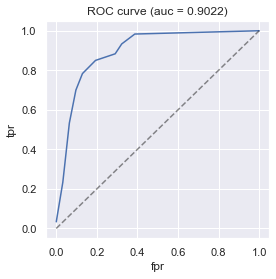

In [180]:
# for Lasso
roc_plot(y_test, logis.predict_proba(X_test)[:,1]) 

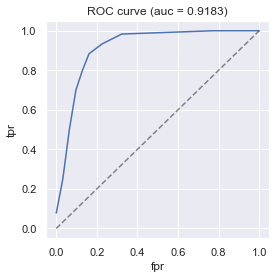

In [181]:
# for svm
roc_plot(y_test,svm_clf.predict_proba(X_test_mix)[:,1]) 

The AUC(Area Under Curve) is 0.92 for SVM and 0.90 for Lasso, the difference is not that significant. Both the models are  able to distinguish between Positives and Negatives pretty well. 

#### c. Feature Importance

There are many methods available to see the importance features for the model. Some of which are Permutation, LogisticRegression, DecisionTrees, RandomForest, Correlation and so on. 

Below, for Lasso, we will use its weights to determine the importance of the features and for SVM, we will use Permutation based approach(a modified version of random forest)

For more information about different types of methods to perform feature importance and its pros/cons, refer https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e <br>
https://mljar.com/blog/feature-importance-in-random-forest/


                             feature  log-odds  abs(log-odds)      sign
19                     vessels_num_2 -0.370203       0.370203  Negative
5                         ex_ind_ang -0.336965       0.336965  Negative
7    chest_pain_type_Atypical angina  0.326575       0.326575  Positive
24                     thal_result_3 -0.302299       0.302299  Negative
6                          prev_peak -0.281632       0.281632  Negative
23                     thal_result_2  0.260478       0.260478  Positive
18                     vessels_num_1 -0.225623       0.225623  Negative
16                           slope_1 -0.220169       0.220169  Negative
4                     max_heart_rate  0.174584       0.174584  Positive
20                     vessels_num_3 -0.078928       0.078928  Negative
15                       age_grp_>55 -0.071464       0.071464  Negative
17                           slope_2  0.061900       0.061900  Positive
0                             gender -0.052164       0.052164  N

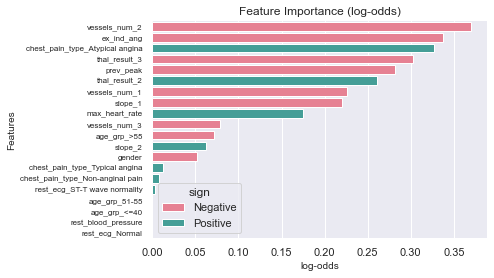

In [182]:
# for Lasso
importance_plots(X_train.columns, log_odds)

In [ ]:
# For SVM

from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_mix, y_train)

perm_importance = permutation_importance(rf, X_train_mix, y_train)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train_mix.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

$Comments:$<br>
For SVM: prev_peak, thal_result_3, vessels_num_1, slope_1, chest pain atypical angina, ex_ind_ang are the top features deciding if the patient will have an heart attack or not.

For Lasso:
1. vessels_num_2:  It indicates the number of coloured vessels seen  i.e. blood passing through. The more the coloured vessels i.e. more blood flows and the better(no clots) . With one unit increase in the vessels_num_2, other covariates being constant, changes the log odds by -0.37. It decreases the chances of heart attack.
2. ex_ind_ang: This field indicates if it is exercise induced angina. With one unit increase in ex_ind_ang, other covariates being constant, changes the log odds by -0.33. It decreases the chances of heart attack.
3. chest_pain_type_Atypical angina: Atypical angina chest pain shows a direct relation to predict if the person is prone to heart disease. With one unit increase for this column, other covariates being constant, changes the log odds by 0.32. 
4. thal_result_3: This is thalium test result. If it is high, then it means no proper blood movement when exercising and the person is more prone to heart attack. With one unit increase for this column, other covariates being constant, changes the log odds by -0.30. 
5. prev_peak: ST depression induced by exercise relative to rest. For unhealthy patients, heart will stress more. With one unit increase for this column, other covariates being constant, changes the log odds by -0.28. 





## 6. Conclusion

The objective of this case study was to predict if the patient will have heart attack or not. We have analysed all the features and have seen their effect in having heart attacks using exploratory data analysis. We followed two approaches, one without doing explicit dimension reduction and another by reducing less important features by RFE and p-value. In the first approach, we applied Lasso Regression, which shrinks the less importance features, and got a recall score of 83.4%. While in the second approach, we have dropped the less important features from the dataset before applying SVM Linear model and using just 10 features with hyperparameters tuning, we have achieved 86.89% accuracy and 90% recall. The difference is not that much for both the models as the size of the dataset is too small. We could have had better picture with large dataset. But for large dataset, we would prefer Lasso model as it is a simple model, reduces the features and complexity of the model and also it doesn't require explicit dimension reduction. For small dataset, we will prefer SVM as it gives better score and generally SVM is not suitable for large dataset.


## 7. Recommendations:

Relating to the most impactful features in deciding the proness to heart attacks, below are some of the general recommendations for patients to bring their chances of heart attacks down:
1. Eat a healthy, balanced diet
2. Be more physically active
3. Keep to a healthy weight
4. Give up smoking
5. Reduce your alcohol consumption
6. Keep your blood pressure under control



## 7. Appendix


### A. Profiling using pandas_profiling

In [45]:
#descriptive statistics
pandas_profiling.ProfileReport(heart_data)

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Comments from Data Profiling:

There is one duplicate record

**age**: 
    - Min_age:29 and Max_age: 77
    - No missing records
    - Highly correlated with **max_heart_rate**
    
**gender**: 
    - # Males:207 and #Females: 96
    - No missing records
    - Highly correlated with **thal_result**

**chest pain type**: 
    - 3 distinct values (Atypical angina:87; Typical angina:50, Non-anginal pain: 23)
    - # missing records: 143
    
**fast_blood_sugar**: 
    - # True:45 and # False: 258

**rest_ecg**: 
    - # Males:207 and #Females: 96
    - No missing records
    - Highly correlated with **prev_peak**

**max_heart_rate**: 
    - Highly correlated with **age, ex_ind_ang and output**

**ex_ind_ang**: 
    - # False:204 and # True:99
    - Highly correlated with **max_heart_rate and output**
    
**prev_peak**: 
    - Highly correlated with **slope and rest_ecg**

**max_heart_rate**: 
    - Highly correlated with **age, ex_ind_ang and output**

**thal_result**: 
    - categorial variable
    - Highly correlated with **gender and output**

**output**:
    - seems to be highly correlated with max_heart_rate, thal_result, and ex_ind_ang
    - Class 1: 165 and Class 0:138 (so no class imbalance problem)


 

### B. Dimension Reductionality using PCA

PCA is a statistical procedure to convert observations of possibly correlated variables into ‘Principal Components’ that are
- Uncorrelated with/independent of each other
- Principal components are constructed to capture maximum information (?) in the data
- The principal components are linear combinations of the original variables

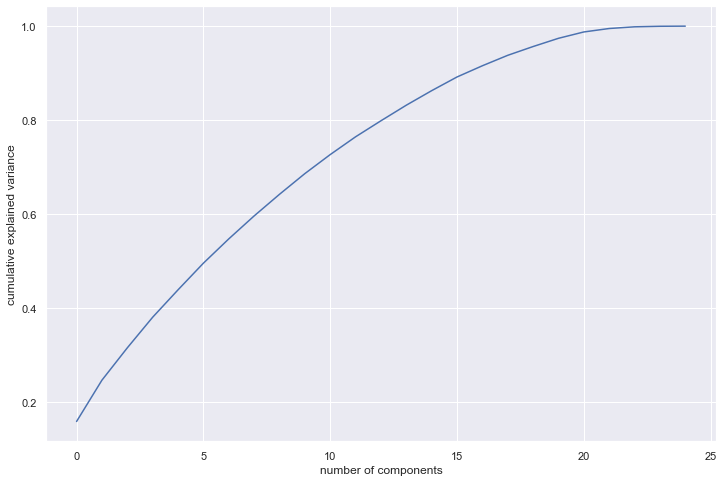

In [158]:
#Importing the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)
#Doing the PCA on the train data
pca.fit(X_train)
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [165]:
# Cut the variance at 85%
from sklearn.decomposition import IncrementalPCA
pca_final = PCA(0.85)
#fit pca model
X_train_pca = pca_final.fit_transform(X_train)
X_train_pca.shape

(242, 15)

In [166]:
# accuracy
X_test_pca = pca_final.transform(X_test)

lr_fun(X_train_pca,y_train,X_test_pca,y_test)

Train accuracy: 0.871900826446281 

Test accuracy: 0.819672131147541 



In [164]:
X_train_pca = X_train[col]
X_test_pca = X_test[col]

results_df_pca = pd.DataFrame(columns=['Model', 'Training Accuracy %', 'Testing Accuracy %','Test Precision %','Test Recall %'])
results_df_pca = my_model("Logistic Regression",LogisticRegression(),X_train_pca,y_train,X_test_pca,y_test,results_df_pca)
results_df_pca = my_model("SVM Linear",SVC(kernel='linear'),X_train_pca,y_train,X_test_pca,y_test,results_df_pca)
results_df_pca = my_model("SVM RBF",SVC(kernel='rbf'),X_train_pca,y_train,X_test_pca,y_test,results_df_pca)
results_df_pca = my_model("Decision Tree",DecisionTreeClassifier(),X_train_pca,y_train,X_test_pca,y_test,results_df_pca)
results_df_pca = my_model("Random Forest",RandomForestClassifier(),X_train_pca,y_train,X_test_pca,y_test,results_df_pca)
results_df_pca = my_model("KNN",KNeighborsClassifier(),X_train_pca,y_train,X_test_pca,y_test,results_df_pca)
results_df_pca = my_model("XGBoost",XGBClassifier(),X_train_pca,y_train,X_test_pca,y_test,results_df_pca)

results_df_pca

[12:47:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\KIRAN ANUMALLA\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,Model,Training Accuracy %,Testing Accuracy %,Test Precision %,Test Recall %,Test F1 Score %
0,Logistic Regression,89.67,85.25,80.00,93.33,86.15
1,SVM Linear,90.50,85.25,80.00,93.33,86.15
2,SVM RBF,92.56,81.97,78.79,86.67,82.54
3,Decision Tree,98.76,77.05,73.53,83.33,78.12
4,Random Forest,98.76,80.33,78.12,83.33,80.65
5,KNN,89.26,83.61,81.25,86.67,83.87
6,XGBoost,98.76,80.33,80.00,80.00,80.00


### C. RFECV method  

In [157]:
from sklearn.feature_selection import RFECV

# Init, fit
rfecv = RFECV(
    estimator=LogisticRegression(),
    min_features_to_select=5,
    step=5,
    n_jobs=-1,
    scoring="r2",
    cv=5,
)

_ = rfecv.fit(X_train, y_train)

print(X_train.columns[rfe.support_])

Index(['gender', 'rest_blood_pressure', 'ex_ind_ang', 'prev_peak',
       'chest_pain_type_Atypical angina', 'chest_pain_type_Non-anginal pain',
       'age_grp_51-55', 'slope_1', 'vessels_num_1', 'vessels_num_2',
       'vessels_num_3', 'thal_result_1', 'thal_result_2'],
      dtype='object')


### D. Hyper parameter tuning for all the models with RFE Feature Selection


#### Hyperparameter Tuning of Logistic Regression

In [51]:
tuning_results_df = pd.DataFrame(columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])

params = {"C": np.logspace(-4, 4, 20),
          "solver": ["liblinear"]}

lr_clf = LogisticRegression()

lr_cv = GridSearchCV(lr_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5, iid=True)
lr_cv.fit(X_train_mix, y_train)
best_params = lr_cv.best_params_
print(f"Best parameters: {best_params}")
lr_clf = LogisticRegression(**best_params)

lr_clf.fit(X_train_mix, y_train)

print_score(lr_clf, X_train_mix, y_train, X_test_mix, y_test, train=True)
print_score(lr_clf, X_train_mix, y_train, X_test_mix, y_test, train=False)

test_score = accuracy_score(y_test, lr_clf.predict(X_test_mix)) * 100
train_score = accuracy_score(y_train, lr_clf.predict(X_train_mix)) * 100

results_df_2 = pd.DataFrame(data=[["Tuned Logistic Regression", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
tuning_results_df = tuning_results_df.append(results_df_2, ignore_index=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Best parameters: {'C': 29.763514416313132, 'solver': 'liblinear'}
Train Result:
Accuracy Score: 88.84%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.900000    0.880282   0.88843    0.890141      0.889000
recall       0.841121    0.925926   0.88843    0.883524      0.888430
f1-score     0.869565    0.902527   0.88843    0.886046      0.887953
support    107.000000  135.000000   0.88843  242.000000    242.000000
_______________________________________________
Confusion Matrix: 
 [[ 90  17]
 [ 10 125]]

Test Result:
Accuracy Score: 83.61%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.888889   0.794118  0.836066   0.841503      0.842280
recall      0.774194   0.900000  0.836066   0.837097      0.836066
f1-score    0.827586   0.843750  0.836066   0.835668      0.835536
support  

[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
C:\Users\KIRAN ANUMALLA\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


#### Hyperparameter tuning for SVM

In [52]:
svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0)

params = {"C":(0.1, 0.5, 1, 2, 5, 10, 20), 
          "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1), 
          "kernel":('linear', 'poly', 'rbf')}

svm_cv = GridSearchCV(svm_clf, params, n_jobs=-1, cv=5, verbose=1, scoring="accuracy")
svm_cv.fit(X_train_mix, y_train)
best_params = svm_cv.best_params_
print(f"Best params: {best_params}")

svm_clf = SVC(**best_params)
svm_clf.fit(X_train_mix, y_train)

print_score(svm_clf, X_train_mix, y_train, X_test_mix, y_test, train=True)
print_score(svm_clf, X_train_mix, y_train, X_test_mix, y_test, train=False)

test_score = accuracy_score(y_test, svm_clf.predict(X_test_mix)) * 100
train_score = accuracy_score(y_train, svm_clf.predict(X_train_mix)) * 100

results_df_2 = pd.DataFrame(data=[["Tuned SVM (Linear)", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
tuning_results_df = tuning_results_df.append(results_df_2, ignore_index=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 147 candidates, totalling 735 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Best params: {'C': 5, 'gamma': 0.001, 'kernel': 'linear'}
Train Result:
Accuracy Score: 87.60%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.888889    0.867133  0.876033    0.878011      0.876752
recall       0.822430    0.918519  0.876033    0.870474      0.876033
f1-score     0.854369    0.892086  0.876033    0.873228      0.875410
support    107.000000  135.000000  0.876033  242.000000    242.000000
_______________________________________________
Confusion Matrix: 
 [[ 88  19]
 [ 11 124]]

Test Result:
Accuracy Score: 86.89%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.960000   0.805556  0.868852   0.882778      0.884044
recall      0.774194   0.966667  0.868852   0.870430      0.868852
f1-score    0.857143   0.878788  0.868852   0.867965      0.867788
support    31.000

[Parallel(n_jobs=-1)]: Done 735 out of 735 | elapsed:    1.6s finished


#### Hyperparameter tuning for DecisionTree

In [53]:
params = {"criterion":("gini", "entropy"), 
          "splitter":("best", "random"), 
          "max_depth":(list(range(1, 10))), 
          "min_samples_split":[2, 3, 4], 
          "min_samples_leaf":list(range(1, 20))
          }

tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3, iid=True)
tree_cv.fit(X_train_mix, y_train)
best_params = tree_cv.best_params_
print(f'Best_params: {best_params}')

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train_mix, y_train)

print_score(tree_clf, X_train_mix, y_train, X_test_mix, y_test, train=True)
print_score(tree_clf, X_train_mix, y_train, X_test_mix, y_test, train=False)

test_score = accuracy_score(y_test, tree_clf.predict(X_test_mix)) * 100
train_score = accuracy_score(y_train, tree_clf.predict(X_train_mix)) * 100

results_df_2 = pd.DataFrame(data=[["Tuned Decision Tree Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
tuning_results_df = tuning_results_df.append(results_df_2, ignore_index=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 2052 candidates, totalling 6156 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 6070 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 6156 out of 6156 | elapsed:   10.4s finished


Best_params: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Train Result:
Accuracy Score: 92.15%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.892857    0.946154  0.921488    0.919505      0.922589
recall       0.934579    0.911111  0.921488    0.922845      0.921488
f1-score     0.913242    0.928302  0.921488    0.920772      0.921643
support    107.000000  135.000000  0.921488  242.000000    242.000000
_______________________________________________
Confusion Matrix: 
 [[100   7]
 [ 12 123]]

Test Result:
Accuracy Score: 72.13%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.750000   0.696970  0.721311   0.723485      0.723920
recall      0.677419   0.766667  0.721311   0.722043      0.721311
f1-score    0.711864  

C:\Users\KIRAN ANUMALLA\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


#### Hyperparameter tuning for RandomForest

In [54]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = range(2, 20, 5)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=3, verbose=2, n_jobs=-1)


rf_cv.fit(X_train_mix, y_train)
best_params = rf_cv.best_params_
print(f"Best parameters: {best_params}")

rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train_mix, y_train)

print_score(rf_clf, X_train_mix, y_train, X_test_mix, y_test, train=True)
print_score(rf_clf, X_train_mix, y_train, X_test_mix, y_test, train=False)

test_score = accuracy_score(y_test, rf_clf.predict(X_test_mix)) * 100
train_score = accuracy_score(y_train, rf_clf.predict(X_train_mix)) * 100

results_df_2 = pd.DataFrame(data=[["Tuned Random Forest Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
tuning_results_df = tuning_results_df.append(results_df_2, ignore_index=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 23.5min finished


Best parameters: {'bootstrap': True, 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 377}
Train Result:
Accuracy Score: 96.28%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.971154    0.956522   0.96281    0.963838      0.962991
recall       0.943925    0.977778   0.96281    0.960852      0.962810
f1-score     0.957346    0.967033   0.96281    0.962189      0.962750
support    107.000000  135.000000   0.96281  242.000000    242.000000
_______________________________________________
Confusion Matrix: 
 [[101   6]
 [  3 132]]

Test Result:
Accuracy Score: 75.41%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.807692   0.714286  0.754098   0.760989      0.761755
recall      0.677419   0.833333  0.754098   0.755376      0.754

#### Hyperparameter tuning for XGBoost

In [55]:
n_estimators = [100, 500, 900, 1000]
max_depth = range(2, 20, 5)
booster = ['gbtree', 'gblinear']
base_score = [0.25, 0.5, 0.75, 0.99]
learning_rate = [0.05, 0.1, 0.15, 0.20]
min_child_weight = [1, 2, 3, 4]

params_grid = {
    'n_estimators': n_estimators, 'max_depth': max_depth,
    'learning_rate' : learning_rate, 'min_child_weight' : min_child_weight, 
    'booster' : booster, 'base_score' : base_score
                      }

xgb_clf = XGBClassifier()

xgb_cv = GridSearchCV(xgb_clf, params_grid, cv=3, scoring = 'accuracy',n_jobs =-1, verbose=1)


xgb_cv.fit(X_train_mix, y_train)
best_params = xgb_cv.best_params_
print(f"Best paramters: {best_params}")

xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train_mix, y_train)

print_score(xgb_clf, X_train_mix, y_train, X_test_mix, y_test, train=True)
print_score(xgb_clf, X_train_mix, y_train, X_test_mix, y_test, train=False)

test_score = accuracy_score(y_test, xgb_clf.predict(X_test_mix)) * 100
train_score = accuracy_score(y_train, xgb_clf.predict(X_train_mix)) * 100

results_df_2 = pd.DataFrame(data=[["Tuned XGBoost", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
tuning_results_df = tuning_results_df.append(results_df_2, ignore_index=True)

Fitting 3 folds for each of 2048 candidates, totalling 6144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 6144 out of 6144 | elapsed: 12.3min finished
C:\Users\KIRAN ANUMALLA\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be remov

[04:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best paramters: {'base_score': 0.25, 'booster': 'gblinear', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100}
[04:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { max_depth, min_child_weight

#### Hyperparameter tuning for KNN

In [56]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

#Convert to dictionary
params_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()


#Use GridSearch
knn_cv = GridSearchCV(knn_2, params_grid, cv=5,scoring = 'accuracy',n_jobs =-1, verbose=1)
#Fit the model
knn_cv.fit(X_train_mix, y_train)

best_params = knn_cv.best_params_
print(f"Best paramters: {best_params}")

knn_clf = XGBClassifier(**best_params)
knn_clf.fit(X_train_mix, y_train)

print_score(knn_clf, X_train_mix, y_train, X_test_mix, y_test, train=True)
print_score(knn_clf, X_train_mix, y_train, X_test_mix, y_test, train=False)

test_score = accuracy_score(y_test, knn_clf.predict(X_test_mix)) * 100
train_score = accuracy_score(y_train, knn_clf.predict(X_train_mix)) * 100

results_df_2 = pd.DataFrame(data=[["Tuned KNN", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
tuning_results_df = tuning_results_df.append(results_df_2, ignore_index=True)

Fitting 5 folds for each of 2842 candidates, totalling 14210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 9600 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 14000 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 14210 out of 14210 | elapsed:   46.5s finished
C:\Users\KIRAN ANUMALLA\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best paramters: {'leaf_size': 13, 'n_neighbors': 14, 'p': 1}
[04:14:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { leaf_size, n_neighbors, p } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:14:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Result:
Accuracy Score: 95.87%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.953271    0.962963  0.958678    0

In [57]:
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,88.842975,83.606557
1,Tuned SVM (Linear),87.603306,86.885246
2,Tuned Decision Tree Classifier,92.148760,72.131148
3,Tuned Random Forest Classifier,96.280992,75.409836
4,Tuned XGBoost,87.190083,83.606557
5,Tuned KNN,95.867769,77.049180
